This is my cats or dogs image classifier. I'm creating this as a project to practice and learn computer vision techniques and prepare me for more in depth image analysis projects in the future.

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras as ks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


Here I set my image parameters and load in the dataset while also putting each image into the cat: (0) or dog: (1) cat-egory.

In [49]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

filenames=os.listdir("./train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append('Dog')
    else:
        categories.append('Cat')

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

This is the creation of the Convolutional Neural Network (CNN). This sets up the object that I will pass the images through and properly defines the process in which it will slide windows over the image neurons to condense the data into a final vector of 2 probabilities which will determine if the image is labeled cat or dog.

In [ ]:
# Create a stack to push on layers of the CNN model
model=ks.Sequential()
# Adds the first layer which detects features of 32 different windows of size 3x3. ReLU gives the model non-linearity.
model.add(ks.layers.Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
# Keeps the outputs normalized for each layer
model.add(ks.layers.BatchNormalization())
# Grabs the most important item or detail from a smaller, 2x2 window.
model.add(ks.layers.MaxPooling2D(pool_size=(2,2)))
# Gets rid of 25% of the neurons randomly for every window to prevent overfitting
model.add(ks.layers.Dropout(0.25))
# Adds the second layer which now repeats what was done above on a more granular scale
model.add(ks.layers.Conv2D(64,(3,3),activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D(pool_size=(2,2)))
model.add(ks.layers.Dropout(0.25))
# Adds the third layer which is even more granular
model.add(ks.layers.Conv2D(128,(3,3),activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D(pool_size=(2,2)))
model.add(ks.layers.Dropout(0.25))
# Flattens the image into a single vector
model.add(ks.layers.Flatten())
# Adds a fully connected layer with 512 neurons to analyze
model.add(ks.layers.Dense(512,activation='relu'))
# Final normalization
model.add(ks.layers.BatchNormalization())
# Dropout even more to be sure of no overfitting
model.add(ks.layers.Dropout(0.5))
# Adds final layer of 2 neurons - in this case these are the likelihood that the image is a cat or dog.
model.add(ks.layers.Dense(2,activation='softmax'))
# Sets how the model will train for loss, optimize itself, and report accuracy stats
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

c:\Users\maxal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now I add callbacks which are limits to my model to prevent stallin and overfitting. I tell the model to stop early if it doesn't improve for 10 epochs and then follow that up by cutting the learning rate in half if it doesn't change in 2 epochs.

In [51]:
#model.summary()

earlystop = ks.callbacks.EarlyStopping(patience = 10)
learning_rate_reduction = ks.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

Here I set up the test and train parameters that will be used for the model. 80/20 split in batches of 20.

In [ ]:
train_df,validate_df = train_test_split(df,test_size=0.20)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [53]:
# Set up the test
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

This block randomly slices and splices (augments) the images to get a larger dataset to train on while also keeping the model on its toes and preventing overfitting.

In [54]:
# Creates training set - Used during to train the model and learn from augmentations of the training images
train_datagen = ks.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train",x_col='filename',y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size)

# Creates validation set - Used during training to improve the model
validation_datagen = ks.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

# Creates test set - Used only AFTER the model is created to examine success of model
test_datagen = ks.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "./test1",x_col='filename',y_col=None,
    target_size=Image_Size,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [55]:
# Model training
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

c:\Users\maxal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 763s 571ms/step - accuracy: 0.5909 - loss: 0.9469 - val_accuracy: 0.6767 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 2/10
   1/1333 ━━━━━━━━━━━━━━━━━━━━ 2:32 114ms/step - accuracy: 0.9333 - loss: 0.3023

c:\Users\maxal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1333/1333 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9333 - loss: 0.3023 - val_accuracy: 0.6775 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 3/10
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 380s 285ms/step - accuracy: 0.6902 - loss: 0.5966 - val_accuracy: 0.7001 - val_loss: 0.5990 - learning_rate: 0.0010
Epoch 4/10
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5333 - loss: 0.6760 - val_accuracy: 0.6957 - val_loss: 0.6015 - learning_rate: 0.0010
Epoch 5/10
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 435s 326ms/step - accuracy: 0.7390 - loss: 0.5298 - val_accuracy: 0.7532 - val_loss: 0.5646 - learning_rate: 0.0010
Epoch 6/10
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8000 - loss: 0.3574 - val_accuracy: 0.7788 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 7/10
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 245s 184ms/step - accuracy: 0.7721 - loss: 0.4883 - val_accuracy: 0.7445 - val_loss: 0.5370 - learning_rate: 0.0010
Epoch 8/10
   1/1333 ━━━━━━━━━━━━━━━━━━━━ 2:45 124ms/step - accuracy: 0.7

In [57]:
model.save("model2_catsVSdogs_10epoch.keras")

In [58]:
# Runs through the test generated files enough times to go over everything
predict = model.predict(test_generator, steps=int(np.ceil(nb_samples/batch_size)))

834/834 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step


In [ ]:
model = load_model("model2_catsVSdogs_10epoch.keras")

Chooses whichever probability is higher and assigns that to the test image. Reverses the formatting to use the label map.

In [59]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

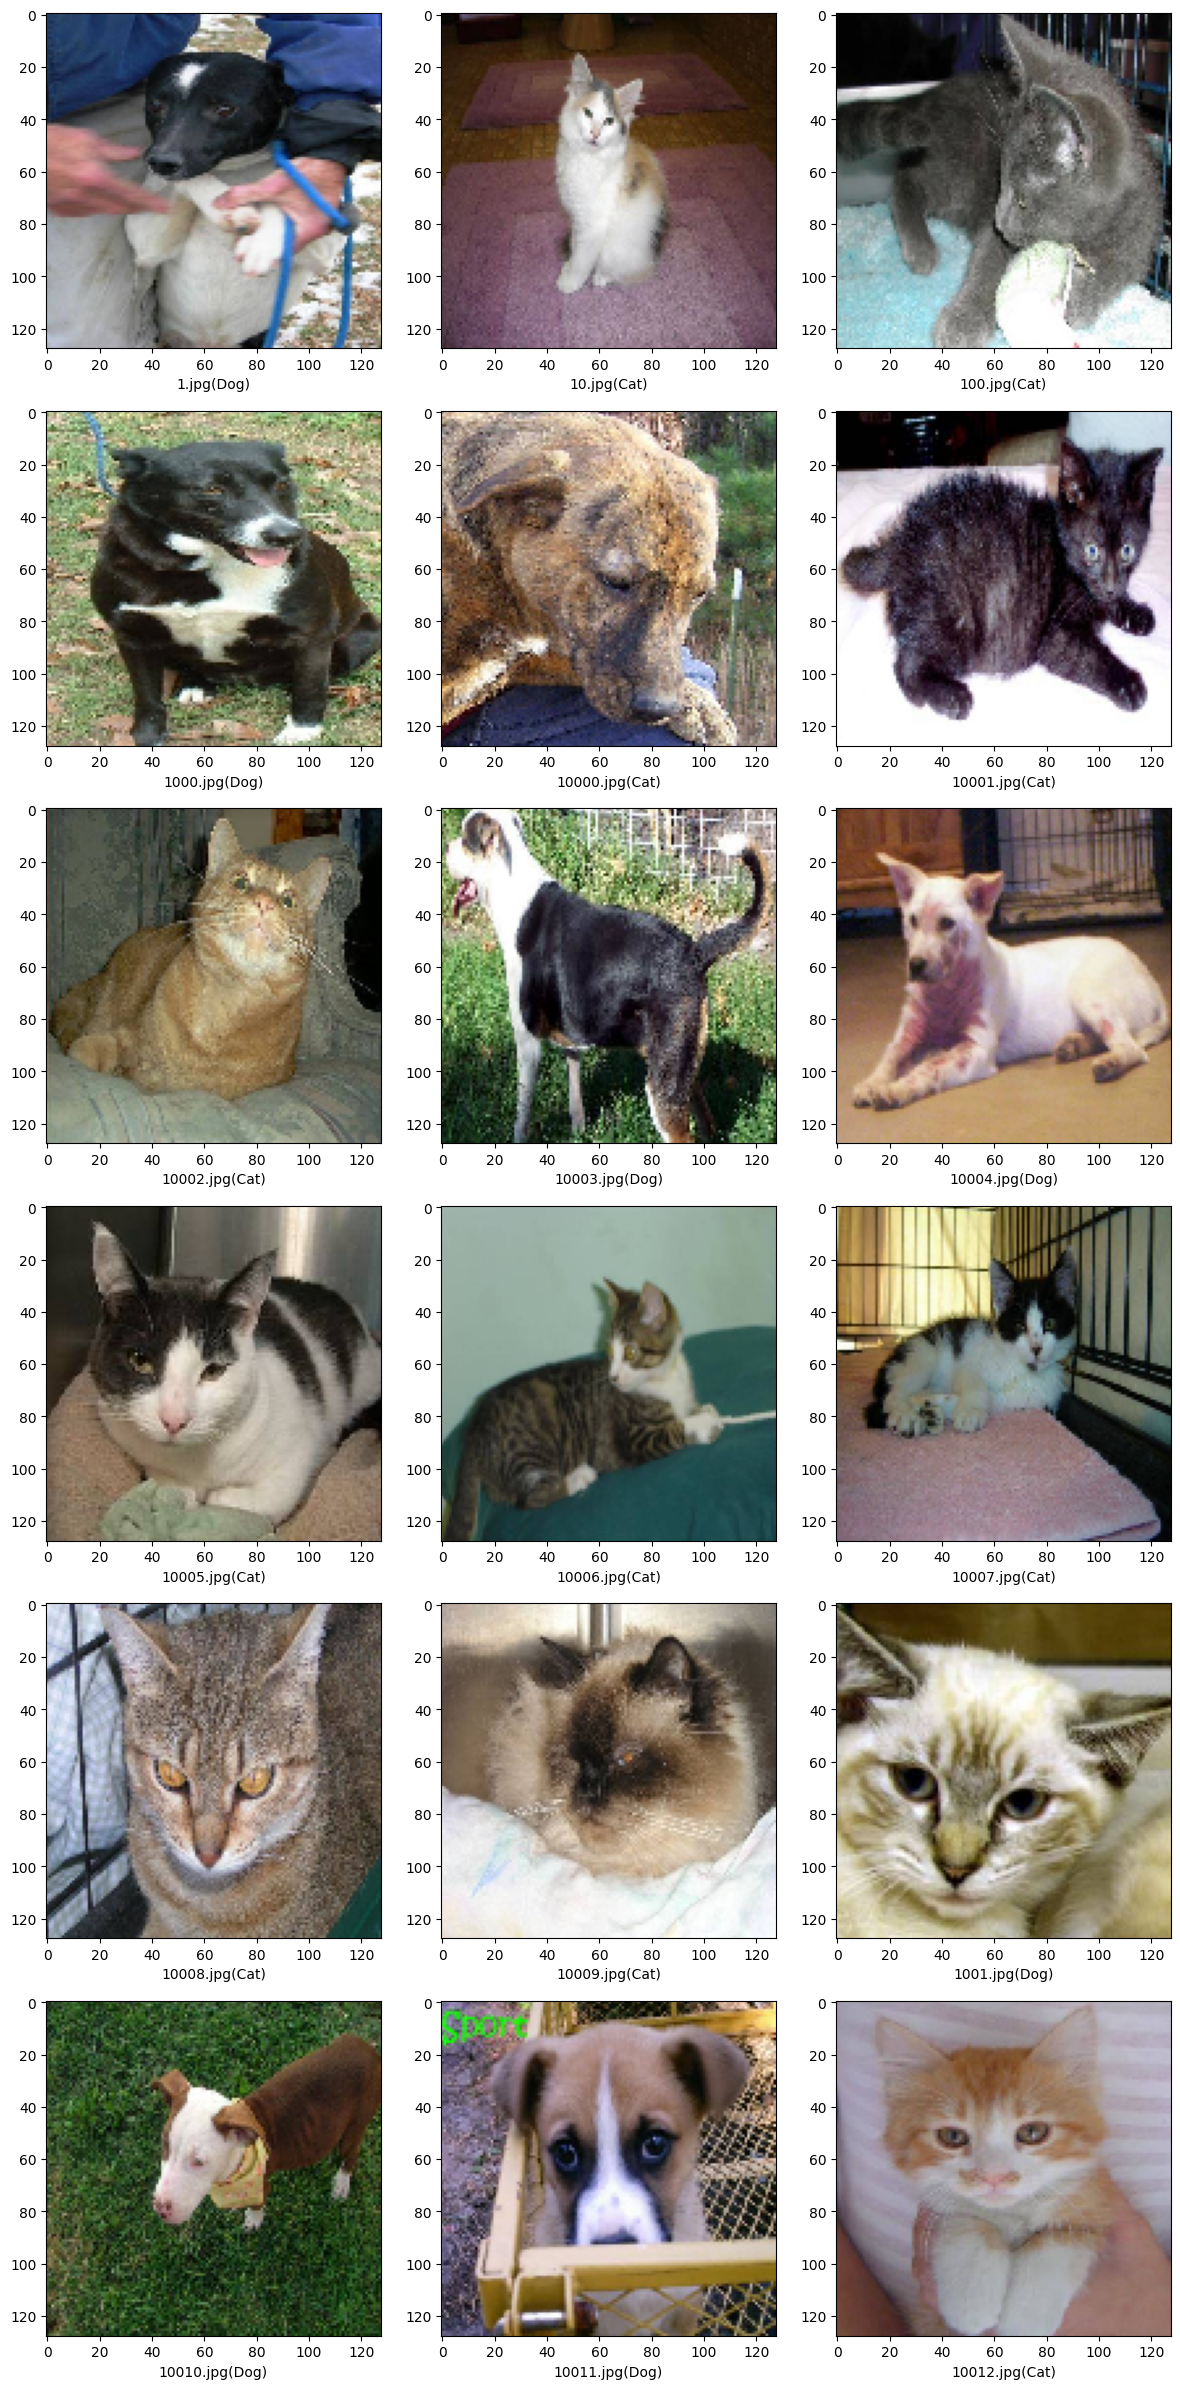

In [61]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = ks.preprocessing.image.load_img("./test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()